### Exercises
    Select a dataset with a continuous target variable.

    Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

    Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
import prepare_telco
import wrangle
import os
from env import user, password, host
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import prepare_telco
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#load wrangled dataset
df=wrangle.wrangle_zillow()

NameError: name 'dummies' is not defined

In [ ]:
df.info(show_counts=True)

In [ ]:
#new column total bill divided by size
df['cost_per_sqft'] = (df['taxvaluedollarcnt']/df['calculatedfinishedsquarefeet']).round(2)

In [ ]:
df.info(show_counts=True)

In [ ]:
#avg sqft per number of rooms (bedroom+bathroom)
df['sqft_room_ratio'] = (df['calculatedfinishedsquarefeet']/(df['bedroomcnt']+df['bathroomcnt'])).round(2)

In [ ]:
df.info(show_counts=True)

In [ ]:
#avg sqft per number of rooms (bedroom+bathroom)
df['sqft_room_ratio'] = (df['calculatedfinishedsquarefeet']/(df['bedroomcnt']+df['bathroomcnt'])).round(2)

In [ ]:
(df.bedroomcnt == 0).value_counts()


In [ ]:
(df.bathroomcnt == 0).value_counts()

In [ ]:
df['bedroomcnt']==0

In [ ]:
df['bathroomcnt']==0

In [ ]:
(df['bedroomcnt']==0)&(df['bathroomcnt']==0)

In [ ]:
df[(df['bedroomcnt']==0)&(df['bathroomcnt']==0)].describe()

In [ ]:
df[(df['bedroomcnt']!=0)&(df['bathroomcnt']!=0)].describe()

at this point after digging into whether or not i can or should impute the values of the averages based on squarefootage or just drop them

In [ ]:
df.drop(df.loc[df['bedroomcnt']==0].index, inplace=True)

In [ ]:
df.drop(df.loc[df['bathroomcnt']==0].index, inplace=True)

In [ ]:
(df.bedroomcnt == 0).value_counts()

In [ ]:
df.head()

In [ ]:
df["fips"] = df["fips"].astype(str)

In [ ]:
df.info(show_counts=True)

In [ ]:
fipsdummies = pd.get_dummies(df.fips)
df = pd.concat([df,fipsdummies],axis=1)

In [4]:
#split the data
train, validate, test = prepare_telco.split(df, stratify_by=None)

NameError: name 'df' is not defined

In [341]:
train.shape, validate.shape, test.shape

((1170059, 12), (501455, 12), (417879, 12))

In [342]:
X_train_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,cost_per_sqft,sqft_room_ratio
0,0.4,0.454545,0.040257,0.000572,0.033553
1,0.2,0.272727,0.015991,0.000981,0.020002
2,0.4,0.272727,0.024468,0.000156,0.024477
3,0.6,0.272727,0.022341,0.000868,0.018623
4,0.4,0.272727,0.024468,0.000408,0.024477
...,...,...,...,...,...
1170054,0.4,0.272727,0.023219,0.000272,0.023227
1170055,0.4,0.272727,0.040747,0.000290,0.040755
1170056,0.6,0.454545,0.029568,0.000362,0.021124
1170057,0.6,0.454545,0.036221,0.000144,0.025876


In [289]:
#remove target from X_train, remove categoricals so it can be modeled
X_train1 = train.drop(columns=['taxvaluedollarcnt','fips','yearbuilt','taxamount','6037','6059','6111'])
y_train1 = train.taxvaluedollarcnt

In [343]:
# from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 2 features
f_selector = SelectKBest(f_regression, k=5)

# find the top 8 X's correlated with y
f_selector.fit(X_train1, y_train1)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train1.iloc[:,feature_mask].columns.tolist()

In [344]:
f_feature

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'cost_per_sqft',
 'sqft_room_ratio']

In [346]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(X_train1,y_train1)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train1.iloc[:,feature_mask].columns.tolist()

In [347]:
rfe_feature

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'cost_per_sqft',
 'sqft_room_ratio']

In [ ]:
#xplore unscaled data Dataframe, Feature variables only, Unscaled, 
#Dummy vars with original categorical vars

In [349]:
X_train = train.drop(columns=['bedroomcnt','bathroomcnt','taxvaluedollarcnt','fips','yearbuilt','taxamount','6037','6059','6111'])
X_validate = validate.drop(columns=['bedroomcnt','bathroomcnt','taxvaluedollarcnt','fips','yearbuilt','taxamount','6037','6059','6111'])
X_test = test.drop(columns=['bedroomcnt','bathroomcnt','taxvaluedollarcnt','fips','yearbuilt','taxamount','6037','6059','6111'])
y_train = train.taxvaluedollarcnt
y_validate = validate.taxvaluedollarcnt
y_test = test.taxvaluedollarcnt

In [350]:
X_train

,calculatedfinishedsquarefeet,cost_per_sqft,sqft_room_ratio
1702590,2385,348.74,397.50
1204794,948,598.10,237.00
855784,1450,95.04,290.00
2033187,1324,529.16,220.67
999881,1450,248.72,290.00
...,...,...,...
1933819,1376,165.78,275.20
2086583,2414,176.87,482.80
2026377,1752,220.94,250.29
1100793,2146,87.52,306.57


In [354]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_train)

train_mms = mms.transform(X_train)

In [355]:
#Is there a mistake here?
X_train_scaled = pd.DataFrame(train_mms, columns=list(X_train.columns))


In [356]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_validate)

validate_mms = mms.transform(X_validate)

In [358]:
#Is there a mistake here?
X_validate_scaled = pd.DataFrame(validate_mms, columns=list(X_validate.columns))

In [359]:
X_validate_scaled

,calculatedfinishedsquarefeet,cost_per_sqft,sqft_room_ratio
0,0.002407,0.000793,0.002750
1,0.001964,0.001628,0.002618
2,0.002828,0.000679,0.003231
3,0.002454,0.001146,0.003272
4,0.002831,0.000350,0.003774
...,...,...,...
501450,0.002660,0.001500,0.002659
501451,0.001641,0.000757,0.003282
501452,0.001254,0.001442,0.002510
501453,0.001976,0.000363,0.003161


Text(0.5, 1.0, 'Scaled')

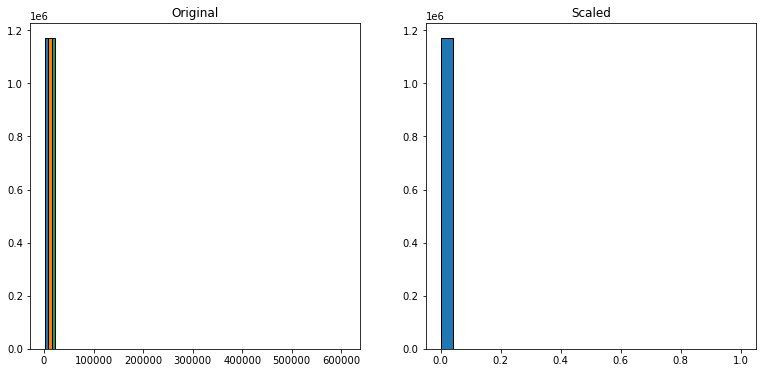

In [362]:
#Visualize the difference between unscaled/scaled data
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_mms[:,1], bins=25, ec='black')
plt.title('Scaled')

(array([320321., 401867., 229418., 107175.,  49707.,  24490.,  15163.,
         10039.,   6878.,   5001.]),
 array([2.2000000e+01, 2.0001930e+05, 4.0001660e+05, 6.0001390e+05,
        8.0001120e+05, 1.0000085e+06, 1.2000058e+06, 1.4000031e+06,
        1.6000004e+06, 1.7999977e+06, 1.9999950e+06]),
 <BarContainer object of 10 artists>)

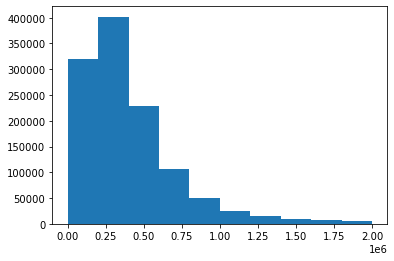

In [363]:
plt.hist(y_train)

In [364]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [365]:
# 1. Predict home_value_pred_mean
home_value_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['home_value_pred_mean'] = home_value_pred_mean
y_validate['home_value_pred_mean'] = home_value_pred_mean

# 2. compute home_value_pred_median
home_value_median = y_train['taxvaluedollarcnt'].median()
y_train['home_value_median'] = home_value_median
y_validate['home_value_median'] = home_value_median

# 3. RMSE of home_value_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.home_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.home_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of home_value_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.home_value_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.home_value_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  313644.26 
Validate/Out-of-Sample:  313020.06
RMSE using Median
Train/In-Sample:  322873.31 
Validate/Out-of-Sample:  322197.37


In [366]:
y_train

,taxvaluedollarcnt,home_value_pred_mean,home_value_median
1702590,831746,399174.008496,322529.0
1204794,567000,399174.008496,322529.0
855784,137805,399174.008496,322529.0
2033187,700607,399174.008496,322529.0
999881,360649,399174.008496,322529.0
...,...,...,...
1933819,228120,399174.008496,322529.0
2086583,426973,399174.008496,322529.0
2026377,387090,399174.008496,322529.0
1100793,187821,399174.008496,322529.0


LinearRegression (OLS)
Fit the model using X_train_scaled and the labels from y_train.

Predict final grade for students in training sample using our model (lm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [367]:
# create the model object
lm = LinearRegression(normalize=True)

In [368]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.taxvaluedollarcnt)

LinearRegression(normalize=True)

In [369]:
# predict train
y_train['taxvaluedollarcnt_lm'] = lm.predict(X_train_scaled)

In [370]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_lm)**(1/2)

In [371]:
# predict validate
y_validate['taxvaluedollarcnt_lm'] = lm.predict(X_validate_scaled)

In [372]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_lm)**(1/2)

In [373]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  252051.20781175254 
Validation/Out-of-Sample:  492082.90031462914


LassoLars

Fit the model using X_train_scaled and the labels from y_train.

Predict final grade for students in training sample using our model (lars).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [374]:
# create the model object
lars = LassoLars(alpha=1.0)

In [375]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.taxvaluedollarcnt)

LassoLars()

In [376]:
# predict train
y_train['taxvaluedollarcnt_pred_lars'] = lars.predict(X_train_scaled)

In [377]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lars)**(1/2)

In [378]:
# predict validate
y_validate['taxvaluedollarcnt_pred_lars'] = lars.predict(X_validate_scaled)

In [379]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lars)**(1/2)

In [380]:
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  252056.3095491584 
Validation/Out-of-Sample:  489762.4722651199


TweedieRegressor (GLM)

Fit the model using X_train_scaled and the labels from y_train.

Predict final grade for students in training sample using our model (glm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [381]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

In [382]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.taxvaluedollarcnt)

TweedieRegressor(alpha=0, power=1)

In [383]:
# predict train
y_train['taxvaluedollarcnt_pred_glm'] = glm.predict(X_train_scaled)

In [384]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_glm)**(1/2)

In [385]:
# predict validate
y_validate['taxvaluedollarcnt_pred_glm'] = glm.predict(X_validate_scaled)

In [386]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm)**(1/2)

In [387]:
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  1506911.3078400525 
Validation/Out-of-Sample:  348663.68218754383


Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + 

sklearn.linear_model.LinearRegression()

Create the new features, based on value indicated for degree for train, validate & test.

Fit the Linear Regression model

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [388]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)


In [389]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm2)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  5.67152942621808 
Validation/Out-of-Sample:  407782.0493020097


In [390]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)

In [391]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm3)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  5.668807610071449 
Validation/Out-of-Sample:  407782.23356308456


In [392]:
y_validate

,taxvaluedollarcnt,home_value_pred_mean,home_value_median,taxvaluedollarcnt_lm,taxvaluedollarcnt_pred_lars,taxvaluedollarcnt_pred_glm,taxvaluedollarcnt_pred_lm2,taxvaluedollarcnt_pred_lm3
1486401,354894,399174.008496,322529.0,5585.934755,8907.087487,311002.971635,69430.560623,69430.139528
1964431,594506,399174.008496,322529.0,18190.424473,20986.820880,309678.973669,116471.614178,116471.392235
1631271,356758,399174.008496,322529.0,9239.504792,12573.058766,311260.364687,69730.639524,69730.203452
1065206,522828,399174.008496,322529.0,14772.220179,17807.811889,308992.463334,102273.681599,102273.348225
951437,183952,399174.008496,322529.0,2628.407834,6132.638548,307884.120126,35952.947828,35952.449392
...,...,...,...,...,...,...,...,...
1984295,741813,399174.008496,322529.0,24629.477694,27473.707934,314317.447589,145044.621248,145044.358939
695898,231073,399174.008496,322529.0,-4701.645305,-1367.475125,302638.419735,45334.290981,45333.861862
1542519,336443,399174.008496,322529.0,4463.131871,7428.563692,304950.896421,66190.461111,66190.201240
1718131,133310,399174.008496,322529.0,-9225.414759,-5632.826042,305113.878976,26112.549009,26112.026416


In [393]:
# # y_validate.head()
# plt.figure(figsize=(10,10))
# plt.rcParams['agg.path.chunksize'] = 10000
# plt.ylim(0, 1_000_000)
# plt.plot(y_validate.taxvaluedollarcnt, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
# # plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
# plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
# # plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

# plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_lm, 
#             alpha=.5, color="red", s=100, label="Model: LinearRegression")
# plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm, 
#             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
# plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2, 
#             alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
# plt.legend()
# plt.xlabel("Actual Home Value")
# plt.ylabel("Predicted Home Value")
# plt.title("Where are predictions more extreme? More modest?")
# plt.show()

In [394]:
# # y_validate.head()
# plt.figure(figsize=(16,8))
# plt.rcParams['agg.path.chunksize'] = 1000
# plt.ylim(0, 500_000)
# plt.axhline(label="No Error")
# plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_lm-y_validate.taxvaluedollarcnt, 
#             alpha=.5, color="red", s=100, label="Model: LinearRegression")
# plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm-y_validate.taxvaluedollarcnt, 
#             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
# plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2-y_validate.taxvaluedollarcnt, 
#             alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
# plt.legend()
# plt.xlabel("Actual Final Grade")
# plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
# plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
# plt.show()

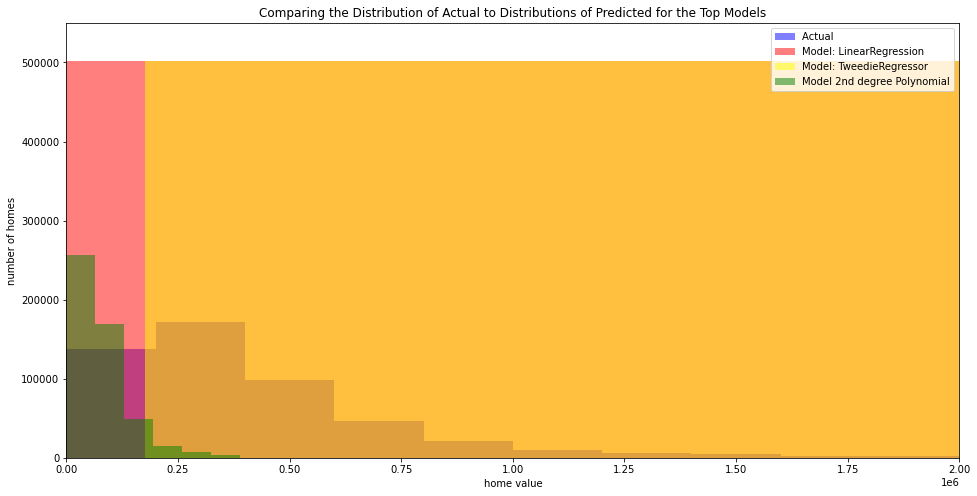

In [396]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.ylim(0, 550_000)
plt.xlim(0, 2_000_000)
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual ")
plt.hist(y_validate.taxvaluedollarcnt_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.taxvaluedollarcnt_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("home value")
plt.ylabel("number of homes")
plt.title("Comparing the Distribution of Actual to Distributions of Predicted for the Top Models")
plt.legend()
plt.show()

Model Selection & Out-of-Sample Evaluation

Model selected: lm (using LinearRegression)

In [400]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_test)

test_mms = mms.transform(X_test)

In [401]:
#Is there a mistake here?
X_test_scaled = pd.DataFrame(test_mms, columns=list(X_test.columns))

In [404]:
X_test_scaled

,calculatedfinishedsquarefeet,cost_per_sqft,sqft_room_ratio
0,0.177670,0.000883,0.148253
1,0.066146,0.001094,0.082806
2,0.053685,0.000557,0.089635
3,0.104727,0.000887,0.104867
4,0.103153,0.000619,0.103291
...,...,...,...
417874,0.086160,0.001517,0.086273
417875,0.325571,0.001023,0.162980
417876,0.100887,0.000133,0.084171
417877,0.147083,0.000952,0.105182


In [402]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvaluedollarcnt_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvaluedollarcnt_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  1324713.8192676313


In [403]:
y_test

,taxvaluedollarcnt,taxvaluedollarcnt_lm
332785,815866,2.522545e+06
925969,376380,9.620086e+05
87705,155656,7.934009e+05
1183010,483265,1.498121e+06
317260,332000,1.469197e+06
...,...,...
1209931,680000,1.241670e+06
1081165,1731614,4.508329e+06
2105453,69738,1.403546e+06
1162662,728162,2.062324e+06


In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

In [ ]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [ ]:
# predict train
y_train['taxvaluedollarcnt_lm'] = lm.predict(X_train_scaled)

In [ ]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_lm)**(1/2)

In [ ]:
# predict validate
y_validate['taxvaluedollarcnt_lm'] = lm.predict(X_validate_scaled)

In [405]:
#create object
lars = LassoLars(alpha=1.0)

In [ ]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [ ]:
# predict train
y_train['taxvaluedollarcnt_pred_lars'] = lars.predict(X_train_scaled)

In [ ]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lars)**(1/2)

In [ ]:
# predict validate
y_validate['taxvaluedollarcnt_pred_lars'] = lars.predict(X_validate_scaled)

In [ ]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lars)**(1/2)

In [ ]:
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [90]:
def scaled_minmax(train, validate, test):
    scaler = MinMaxScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    validate_scaled = scaler.transform(validate)
    test_scaled = scaler.transform(test)
    return train_scaled, validate_scaled, test_scaled

In [98]:
#scale
train_scaled, validate_scaled, test_scaled= scaled_minmax(train, validate, test)

In [99]:
train_scaled

array([[0.4       , 0.45454545, 0.04025735, ..., 1.        , 0.        ,
        0.        ],
       [0.2       , 0.27272727, 0.01599149, ..., 0.        , 1.        ,
        0.        ],
       [0.4       , 0.27272727, 0.0244685 , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.6       , 0.45454545, 0.02956821, ..., 1.        , 0.        ,
        0.        ],
       [0.6       , 0.45454545, 0.03622148, ..., 1.        , 0.        ,
        0.        ],
       [0.4       , 0.27272727, 0.02098989, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
#establish baseline

In [ ]:
#fit model to train

In [ ]:
#build df with model predictions